## Introduction

In this notebook, we attempt to predict whether trading the stock index mentioned in a tweet will yield a return greater than 1%, given the popularity, sentiment scores and other features related to the tweet. We assume that we enter into a long position in the stock index at a fixed time, $t_1$, after the tweet, and we similarly sell off the index at a later fixed time, $t_2$. These $t_1$ and $t_2$ are generally treated as hyperparameters and <b> not as features. </b>

We will use 2 Bayesian-based classifiers in this notebook: Naive Bayes Classifier and quadratic discriminant analysis (QDA).




## Naive Bayes Classifier

Recall that the Naive Bayes Model assumes that the likelihood distribution, $P(X_j|y=c)$, for each class $c$ and feature $j$ is independent. To adhere to this central assumption for the model, we will only include features that are not strongly correlated to one another. 

We begin by downloading the data and performing the train-test split. 

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_parquet("/Users/josht/Documents/tweet_stock_merged_data1.parquet")

In [3]:
df.sample(5)

,time_stamp,entities_cashtags,entities_hashtags,entities_urls,like_count,quote_count,reply_count,retweet_count,text,entities_mentions,...,Company_ticker,time_of_day,morning,evening,night,buy_price,delta_buy,sell_price,delta_sell,return
42936,2021-02-01 10:30:11,0,0,2,40,4,9,19,Facebook to prompt users about personalized ad...,0,...,AAPL,morning,0,1,0,132.300214,49.0,136.394886,322309.0,3.094985
19615,2021-06-29 02:24:46,0,0,1,1,1,0,0,The news that a judge threw out an antitrust l...,0,...,FB,night,0,0,1,356.410000,6314.0,354.070000,300014.0,-0.656547
38152,2021-07-14 06:30:48,2,3,1,0,0,0,0,$IKTSF $IKTSY - Intertek: Technically Not A Ba...,0,...,A,morning,0,1,0,150.428459,9852.0,146.813063,441912.0,-2.403399
11570,2020-01-29 17:41:04,0,0,2,24,2,5,17,"Cloud, Windows sales power Microsoft earnings ...",0,...,MSFT,afternoon,1,0,0,169.822678,56.0,167.811027,382796.0,-1.184560
73328,2020-10-04 15:00:16,1,0,2,19,1,1,9,“Investor horizons have changed a lot in the l...,0,...,V,afternoon,1,0,0,199.220118,46844.0,201.463006,316844.0,1.125834


In [4]:
df.columns

Index(['time_stamp', 'entities_cashtags', 'entities_hashtags', 'entities_urls',
       'like_count', 'quote_count', 'reply_count', 'retweet_count', 'text',
       'entities_mentions', 'created_at_user', 'followers_count',
       'following_count', 'listed_count', 'tweet_count', 'media_type',
       'Company_name', 'Word_count_News_agencies', 'Word_count_Henry08_pos',
       'Word_count_Henry08_neg', 'Word_count_LM11_pos', 'Word_count_LM11_neg',
       'Word_count_Hagenau13_pos', 'Word_count_Hagenau13_neg',
       'Tweet_Length_characters', 'Tweet_Length_words', 'Compound_vader',
       'Positive_vader', 'Negative_vader', 'Neutral_vader', 'Company_ticker',
       'time_of_day', 'morning', 'evening', 'night', 'buy_price', 'delta_buy',
       'sell_price', 'delta_sell', 'return'],
      dtype='object')

In [5]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size = 0.2, shuffle = True)

In [6]:
df.shape

(724283, 40)

In [7]:
df_train.shape

(579426, 40)

In [8]:
df_test.shape

(144857, 40)

These are the potential features we will use in our model. The last three are categorical and result from onehot encoding. We will drop the last one to avoid redundancy. 

In [9]:
potential_features = ['like_count', 'quote_count', 'reply_count', 'retweet_count', 'followers_count', 
                      'following_count', 'listed_count', 'tweet_count', 'Word_count_News_agencies', 
                      'Word_count_Henry08_pos', 'Word_count_Henry08_neg', 'Word_count_LM11_pos', 
                      'Word_count_LM11_neg', 'Word_count_Hagenau13_pos', 'Word_count_Hagenau13_neg', 
                      'Tweet_Length_characters', 'Tweet_Length_words', 'Compound_vader', 'Positive_vader', 
                      'Negative_vader', 'Neutral_vader', 'morning', 'evening', 'night']

Now, we employ PCA to select uncorrelated quantitative features.

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
pca = PCA()

In [11]:
X_quant_train = np.array(df_train[potential_features[:-3]])

In [12]:
X_qt_st = scaler.fit_transform(X_quant_train)
phi_train = pca.fit_transform(X_qt_st)

In [13]:
phi_train.shape

(579426, 21)

In [14]:
print(100 * pca.explained_variance_ratio_)

[1.41037667e+01 1.30426644e+01 1.16499403e+01 1.06370918e+01
 8.93489925e+00 5.53213363e+00 5.06115021e+00 4.43312671e+00
 4.17097343e+00 3.90031319e+00 3.70874504e+00 3.42101766e+00
 2.66793109e+00 2.58431616e+00 2.40773444e+00 2.35031053e+00
 4.64879014e-01 4.49252356e-01 2.68984238e-01 2.10761571e-01
 8.19476268e-06]


Let us get rid of the last five features, as they contribute little to the total variance. Since we centered and scaled the data before applying PCA, the resulting principal components are uncorrelated to one another.

In [15]:
X_train = np.concatenate((phi_train[:, :-5], np.array(df_train[['morning', 'evening']])), axis=1)

In [16]:
np.shape(X_train)

(579426, 18)

In [17]:
phi_test = pca.fit_transform(scaler.fit_transform(np.array(df_test[potential_features[:-3]])))
X_test = np.concatenate((phi_test[:, :-5], np.array(df_test[['morning', 'evening']])), axis=1)

In [18]:
np.shape(X_test)

(144857, 18)

In [19]:
y_train = np.array(df_train["return"] >= 1.0)
y_test = np.array(df_test["return"] >= 1.0)

Now, we are ready to train our Naive Bayes Classifier on the training set.

In [20]:
from sklearn.naive_bayes import GaussianNB

In [21]:
NB = GaussianNB()

NB.fit(X_train, y_train)

GaussianNB()

In [22]:
pred_train = NB.predict(X_train)

In [23]:
acc_train = sum(pred_train == y_train)/y_train.shape[0]
print("Training accuracy:", acc_train)

Training accuracy: 0.6225039953333126


In [24]:
pred_test = NB.predict(X_test)
acc_test = sum(pred_test == y_test)/y_test.shape[0]
print("Test accuracy:", acc_test)

Test accuracy: 0.6217856230627447


In [50]:
from sklearn.metrics import roc_auc_score

auc_train = roc_auc_score(y_train, pred_train)
print("Training ROC AUC:", auc_train)

auc_test = roc_auc_score(y_test, pred_test)
print("Test ROC AUC:", auc_test)

Training ROC AUC: 0.5009203120209449
Test ROC AUC: 0.5003850001527081


:(

## Quadratic Discriminant Analysis

QDA assumes that the joint likelihood distribution for each class $c$ is a multivariate normal distribution: $P(X_1,\ldots,X_m|y=c) \sim \mathcal{N}(\mu_c, \Sigma_c)$. In order to closely approximate the model assumption, we will take the logarithm of some of the features whose distributions are highly skewed to the right.

Then, the natural starting point is to look at the histogram of all quantitative features.

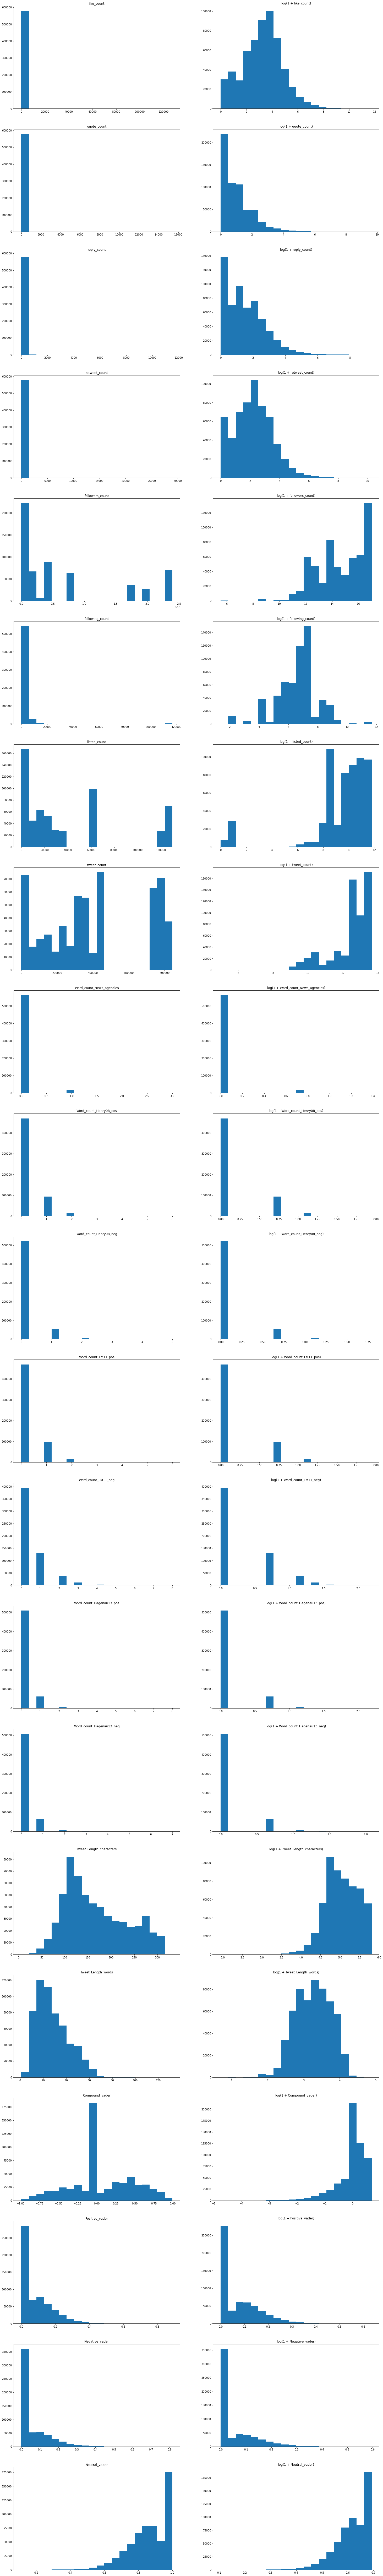

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(potential_features)-3, 2, figsize=(25,180))

for i in range(len(potential_features)-3):
    ax[i, 0].hist(df_train[potential_features[i]], bins=20)
    ax[i, 0].set_title(potential_features[i])
    ax[i, 1].hist(np.log(1 + df_train[potential_features[i]]), bins=20)
    ax[i, 1].set_title("log(1 + "+potential_features[i]+")")

It is unfortunately the case for a lot of features that neither its logarithm nor the feature itself is normally distributed. However, we will do the best we can. The features whose distribution become closer to normal distribution once one takes the logarithm are listed below. 

In [42]:
features_log = ['like_count', 'quote_count', 'reply_count', 'retweet_count', 'following_count', 
                'Tweet_Length_characters', 'Tweet_Length_words']
features_non_log = [x for x in potential_features[:-1] if x not in features_log]

In [43]:
X_train2 = np.concatenate((np.array(np.log(1 + df_train[features_log])), 
                          np.array(df_train[features_non_log])), axis=1)
X_test2 = np.concatenate((np.array(np.log(1 + df_test[features_log])), 
                          np.array(df_test[features_non_log])), axis=1)

In [44]:
y_train2 = np.array(df_train["return"] >= 1.0)
y_test2 = np.array(df_test["return"] >= 1.0)

In [47]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

QDA = QuadraticDiscriminantAnalysis()

In [48]:
QDA.fit(X_train2, y_train2)

QuadraticDiscriminantAnalysis()

In [49]:
pred_train2 = QDA.predict(X_train2)
acc_train2 = sum(pred_train2 == y_train2)/y_train2.shape[0]
print("Training accuracy:", acc_train2)

pred_test2 = QDA.predict(X_test2)
acc_test2 = sum(pred_test2 == y_test2)/y_test2.shape[0]
print("Test accuracy:", acc_test2)

Training accuracy: 0.6218447221905817
Test accuracy: 0.6213576147510994


In [51]:
auc_train2 = roc_auc_score(y_train2, pred_train2)
print("Training ROC AUC:", auc_train2)

auc_test2 = roc_auc_score(y_test2, pred_test2)
print("Test ROC AUC:", auc_test2)

Training ROC AUC: 0.5031016369171176
Test ROC AUC: 0.5023220988463392


:(